# imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import Uncertainty as unc
import UncertaintyM as uncM
import Data.data_provider as dp
import matplotlib.pyplot as plt

# Loading data

In [2]:
# data_name = "spambase"
data_name = "amazon_movie"
features, target = dp.load_data(data_name)

# split and shuffel the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=True, random_state=1)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=1)

Loaded .//amazon-movie-reviews-10000/text.pickle
Loaded .//amazon-movie-reviews-10000/doc2vec.dim50-epochs50.embeddings.pickle


In [3]:
model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("model test score = ", model.score(X_test, y_test))

model test score =  0.82625


In [4]:
total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc.model_uncertainty(model, X_test, X_train, y_train)

In [5]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

model_calib = CalibratedClassifierCV(model, cv=5, method="isotonic")
model_calib_sigmoid = CalibratedClassifierCV(model, cv=5, method="sigmoid")

model_calib.fit(X_train, y_train)
print("model test score = ", model_calib.score(X_test, y_test))
model_calib_sigmoid.fit(X_train, y_train)
print("model test score = ", model_calib_sigmoid.score(X_test, y_test))

total_uncertainty_calib = unc.calib_ens_total_uncertainty(model_calib, X_test)
total_uncertainty_calib_sigmoid = unc.calib_ens_total_uncertainty(model_calib_sigmoid, X_test)

model test score =  0.85475
model test score =  0.8535


In [6]:
total_uncertainty_mcalib, epistemic_uncertainty_mcalib, aleatoric_uncertainty_mcalib = unc.calib_ens_member_uncertainty(model, X_test, X_train, y_train, X_valid, y_valid)
total_uncertainty_mcalib_sigmoid, epistemic_uncertainty_mcalib_sigmoid, aleatoric_uncertainty_mcalib_sigmoid = unc.calib_ens_member_uncertainty(model, X_test, X_train, y_train, X_valid, y_valid, calib_method="sigmoid")

In [7]:
epistemic_uncertainty_mcalib2 = total_uncertainty - aleatoric_uncertainty_mcalib
epistemic_uncertainty_mcalib3 = total_uncertainty_calib - aleatoric_uncertainty_mcalib

epistemic_uncertainty_mcalib3_sigmoid = total_uncertainty_calib_sigmoid - aleatoric_uncertainty_mcalib_sigmoid

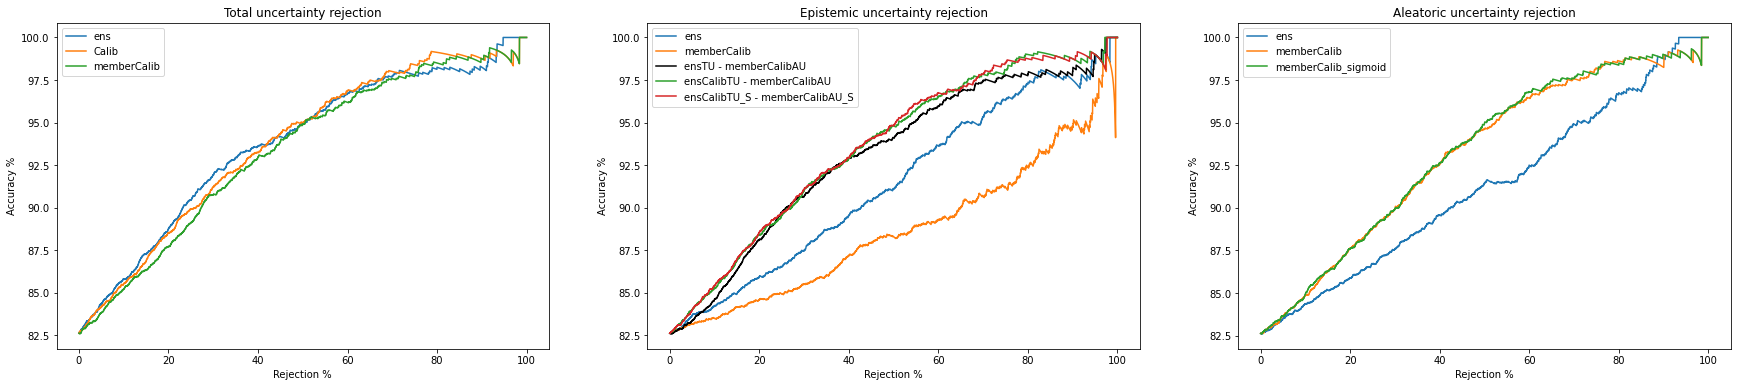

In [8]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(3*2)
fig.set_figwidth(15*2)

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), total_uncertainty.reshape((1,-1)))
avg_acc_c, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), total_uncertainty_calib.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), total_uncertainty_mcalib.reshape((1,-1)))
axs[0].plot(steps, avg_acc*100, label='ens')
axs[0].plot(steps, avg_acc_c*100, label='Calib')
axs[0].plot(steps, avg_acc_mc*100, label='memberCalib')
axs[0].legend()
axs[0].set_title("Total uncertainty rejection")

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty_mcalib.reshape((1,-1)))
avg_acc_mc2, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty_mcalib2.reshape((1,-1)))
avg_acc_mc3, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty_mcalib3.reshape((1,-1)))
avg_acc_mc3s, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty_mcalib3_sigmoid.reshape((1,-1)))

axs[1].plot(steps, avg_acc*100,label='ens')
axs[1].plot(steps, avg_acc_mc*100, label='memberCalib')
axs[1].plot(steps, avg_acc_mc2*100, label='ensTU - memberCalibAU', color="black")
axs[1].plot(steps, avg_acc_mc3*100, label='ensCalibTU - memberCalibAU')
axs[1].plot(steps, avg_acc_mc3s*100, label='ensCalibTU_S - memberCalibAU_S')
axs[1].set_title("Epistemic uncertainty rejection")
axs[1].legend()

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), aleatoric_uncertainty.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), aleatoric_uncertainty_mcalib.reshape((1,-1)))
avg_acc_mcs, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), aleatoric_uncertainty_mcalib_sigmoid.reshape((1,-1)))

axs[2].plot(steps, avg_acc*100, label='ens')
axs[2].plot(steps, avg_acc_mc*100, label='memberCalib')
axs[2].plot(steps, avg_acc_mcs*100, label='memberCalib_sigmoid')
axs[2].set_title("Aleatoric uncertainty rejection")
axs[2].legend()

for i in range(3):
    axs[i].set(xlabel="Rejection %", ylabel="Accuracy %")

fig.show()

# Out of distribution Data test